In [2]:
import copy
import random
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torchvision import datasets
import torchvision.transforms as transforms
from models.cnn1 import My_CNN
from utils.stream_metrics import StreamClsMetrics

import datasets.np_transforms as nptr
from datasets.femnist import Femnist

from utils.args import get_parser
import sys
import os 
import json

import wandb

imageDim = 28*28

def set_seed(random_seed):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def set_metrics():
    num_classes = 62
    
    metrics = {
            'eval_train': StreamClsMetrics(num_classes, 'eval_train'),
            'test': StreamClsMetrics(num_classes, 'test'),
            'l1O': StreamClsMetrics(num_classes, 'l1O')
    }
    
    return metrics

@staticmethod
def update_metric(metric, outputs, labels):
    _, prediction = outputs.max(dim=1)
    labels = labels.cpu().numpy()
    prediction = prediction.cpu().numpy()
    metric.update(labels, prediction)

def get_transforms_rotated():
    
    normalize = transforms.Normalize(
    mean=0.1736,
    std=0.3248,
    )

    angles = [0, 15, 30, 45, 60, 75]
    myAngleTransforms = []
    for theta in angles:
        t = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(degrees=(theta, theta), fill=(1,)),
            transforms.ToTensor(),
            normalize,
        ])
        myAngleTransforms.append(copy.deepcopy(t))

    test_transforms = nptr.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])

    return myAngleTransforms, test_transforms

class MotionBlur(object):
    def __init__(self, size = 28):
        self.size = size
        self.kernel1 = np.ones((3, 3), np.float32)/10
        
    def __call__(self, image):
        image = cv2.filter2D(src = np.array(image), ddepth = -1, kernel = self.kernel1)
        image = torch.from_numpy(image)
        return image
    
    def __repr__(self):
        return self.__class__.__name__+'()'
    
class add_noise(object):
    def __call__(self, inputs, noise_factor=0.15):
        """
        :param img: (Tensor): Image 

        :return: Noisy image (Tensor)
        """
        
        noisy = inputs + torch.randn_like(inputs) * noise_factor
        noisy = torch.clip(noisy, 0., 1.)
        return noisy

    def __repr__(self):
        return self.__class__.__name__+'()'

def get_personal_transforms():
    normalize = transforms.Normalize(
    mean=0.1736,
    std=0.3248,
    )

    angles = [0, 15, 30, 45, 60, 75]
    myAngleTransforms = []
    for theta in angles:
        if theta == 0:
            t = transforms.Compose([
                transforms.ToTensor(),
                normalize,
            ])
        elif theta == 15:
            t = transforms.Compose([
                transforms.ToTensor(),
                MotionBlur(), 
                normalize,
            ])
        elif theta == 30:
            t = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomInvert(p=1.0),
                normalize,
            ]) 
        elif theta == 45:
            t = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomRotation(degrees=(theta, theta), fill=(1,)),
                normalize,
            ])
        elif theta == 60:
            t = transforms.Compose([
                transforms.ToTensor(),
                add_noise(),
                normalize,
            ])
        elif theta == 75:
            t = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomAffine(degrees=0, translate=(0.25,0.25), scale=(0.8,1.2), fill=1),
                normalize,
            ])
        myAngleTransforms.append(copy.deepcopy(t))

    test_transforms = nptr.Compose([
        transforms.ToTensor(),
        normalize,
    ])
    
    return myAngleTransforms, test_transforms

def apply_transforms(train_datasets, test_datasets):
    l1o_datasets = []

    train_transform_list, test_transforms = get_transforms_rotated()

    total_clients = 1002
    n_clients_per_angle = total_clients // 6
    for i, dataset in enumerate(train_datasets):
        transform_to_do = i // n_clients_per_angle
        dataset.set_transform(train_transform_list[ transform_to_do if i < total_clients else 0 ])

    for dataset in test_datasets:
        dataset.set_transform(test_transforms)

    return train_datasets, test_datasets, l1o_datasets

def my_read_femnist_dir(data_dir, is_test_mode = False):
    data = []
    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.json')]
    random.shuffle(files)
    files = np.random.choice(files, size = len(files)//16)
    

    i = 1
    for f in files:
        #Loading bar
        sys.stdout.write('\r')
        sys.stdout.write("%d / %d" % (i, len(files)))
        sys.stdout.flush()
        file_path = os.path.join(data_dir, f)
        
        with open(file_path, 'r') as inf:
            cdata = json.load(inf)
            for user, images in cdata['user_data'].items():    
                data.append(Femnist(images, None, user))
        i += 1
    
    return data

def unify_clients(dataset):
    all_data = {}
    all_data['x'] = []
    all_data['y'] = []
    i = 0

    for client in dataset: 
        list_ = client.get_list_of_samples()

        for img, label in list_:
            all_data['x'].append(img)
            all_data['y'].append(label)
        i += 1
        if i == 10: return all_data
    
    return Femnist(all_data, None, "Centralised User")

def my_read_femnist_data(train_data_dir, test_data_dir, is_test_mode):
    return my_read_femnist_dir(train_data_dir, is_test_mode), \
           my_read_femnist_dir(test_data_dir, is_test_mode)

def get_datasets():

    train_datasets = []

    niid = False
    train_data_dir = os.path.join('data', 'femnist', 'data', 'niid' if niid else 'iid', 'train')
    test_data_dir = os.path.join('data', 'femnist', 'data', 'niid' if niid else 'iid', 'test')
    train_datasets, test_datasets = my_read_femnist_data(train_data_dir, test_data_dir, True)

    return train_datasets, test_datasets

In [44]:
p = 0.25

set_seed(111)

train_datasets, _ = get_datasets()

images = unify_clients(train_datasets)

2 / 2

Images è una lista con 10 immagini, è possibile vedere singolarmente queste cambiando la i nella prossima window, e da lì si possono selezionare le immagini che si preferiscono, dopodichè con i due snippet alla fine è possibile salvare per ogni trasforamzione una immagine andando semplicemente a definire la cartella di destinazione

label 4


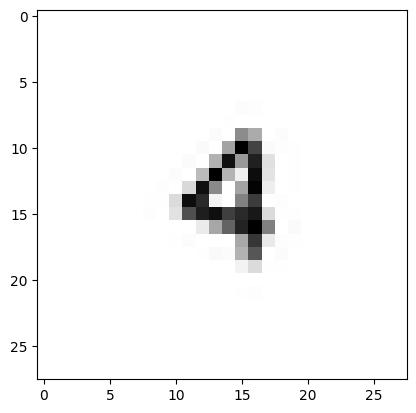

In [52]:
i = 6
img = images["x"][i]
label = images["y"][i]
img = np.array(img).reshape(28,28)
print("label", label)
plt.imshow(img, cmap="gray")
plt.show()

label 4


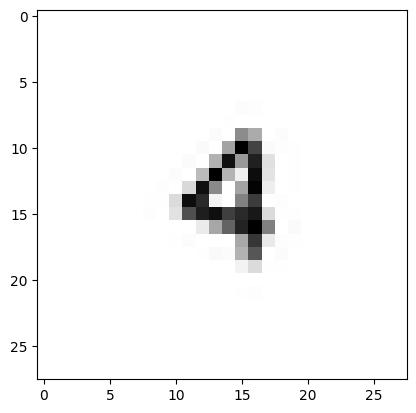

In [53]:
#img1 = images["x"][6]
#label1 = images["y"][6]
img1 = img
img1 = np.array(img1).reshape(28,28)
print("label", label)
plt.imshow(img1, cmap="gray")
plt.show()

label 0


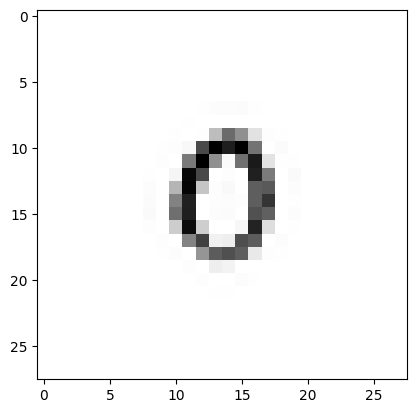

In [28]:
img2 = images["x"][0]
label2 = images["y"][0]
img2 = np.array(img2).reshape(28,28)
print("label", label2)
plt.imshow(img2, cmap="gray")
plt.show()

label 16


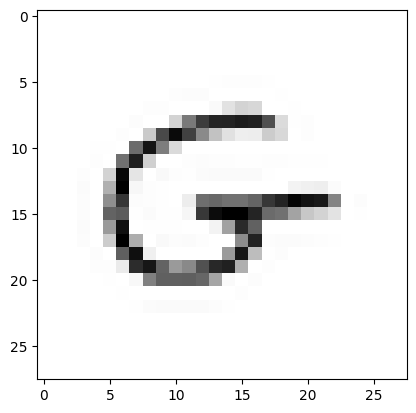

In [41]:
i = 7
img3 = images["x"][i]
label3 = images["y"][i]
img3 = np.array(img3).reshape(28,28)
print("label", label3)
plt.imshow(img3, cmap="gray")
plt.show()

label 39


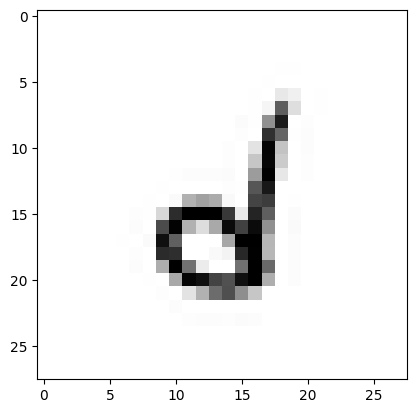

In [52]:
i = 8
img4 = images["x"][i]
label4 = images["y"][i]
img4 = np.array(img4).reshape(28,28)
print("label", label4)
plt.imshow(img4, cmap="gray")
plt.show()

In [29]:
angle_transformations, _ = get_transforms_rotated()
personal_transformations, _ = get_personal_transforms()

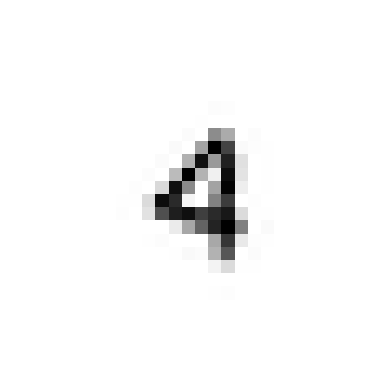

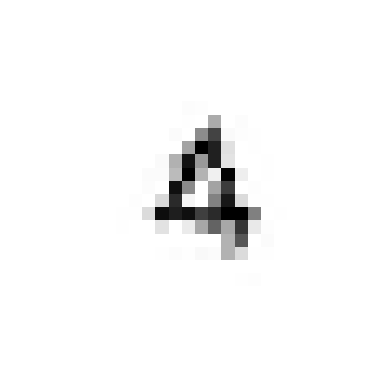

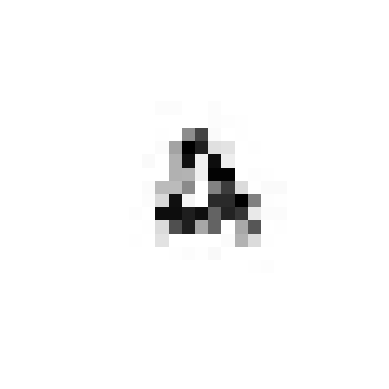

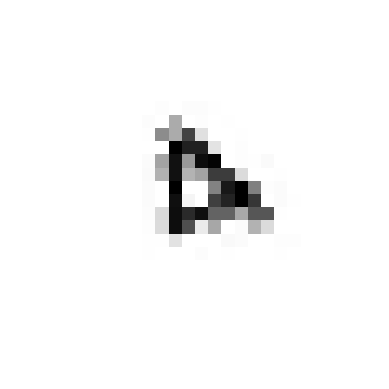

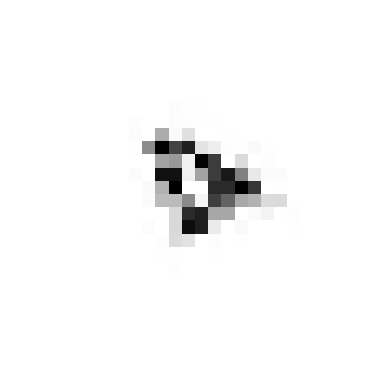

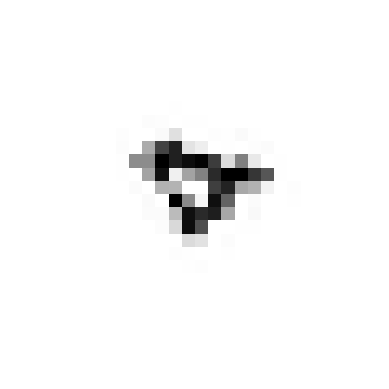

In [54]:
path = os.path.join('Images_Samples', '1bis')
temp = img1
for i, tr in enumerate(angle_transformations):
    img_np = np.array(temp, dtype=np.float32).reshape((28,28))
    img_tr = tr( img_np )
    res = np.array(img_tr).reshape(28,28)
    fig, ax = plt.subplots()
    ax.axis('off')
    plt.imshow(res, cmap="gray")
    folder = path + f'\\{i*15}.png' 
    plt.savefig(folder, bbox_inches='tight', pad_inches=0.0)

In [57]:
list_names = ["a - normal image", "b - MotionBlur", "c - InvertColors", "d - 45degree rotation", "e - noise", "f - random translation"]
set_seed(11)

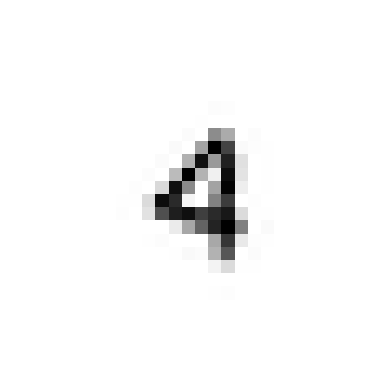

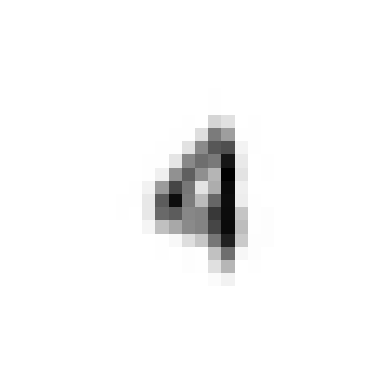

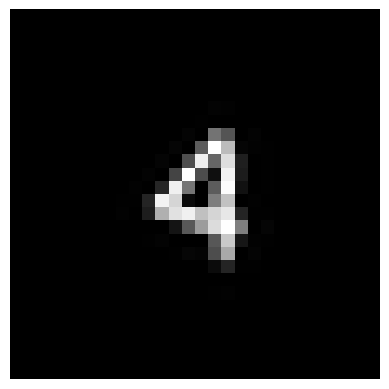

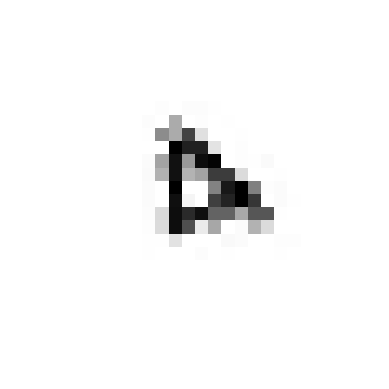

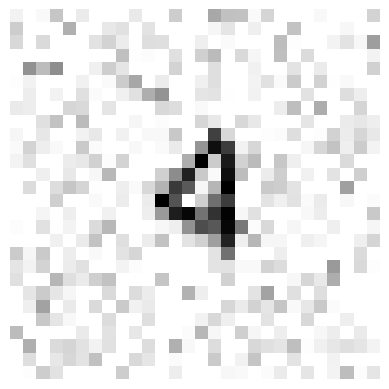

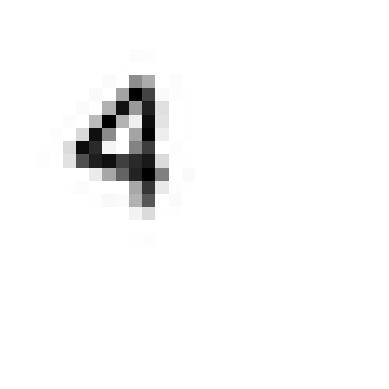

In [58]:
path = os.path.join('Images_Samples', '1bis')
temp = img1
for i, tr in enumerate(personal_transformations):
    img_np = np.array(temp, dtype=np.float32).reshape((28,28))
    img_tr = tr( img_np )
    res = np.array(img_tr).reshape(28,28)
    fig, ax = plt.subplots()
    ax.axis('off')
    plt.imshow(res, cmap="gray")
    folder = path + f'\\{list_names[i]}.png' 
    plt.savefig(folder, bbox_inches='tight', pad_inches=0.0)